# Fig. 2, Extended Fig. 2: Circular reward-relative cell identification

### Table of contents

[Load multiDayData, where cells have already been classified by remapping type](#Load-pre-saved-multiDayData)  \
[Inspect cells by remapping type](#Inspect-cells-by-remapping-type)  \
[Plot example place cells by remapping type](#Plot-example-place-cells-by-remapping-type)  \
[Count cells by remapping type](#Count-cells-by-remapping-type)  \
[Test whether reward-relative remapping exceeds chance](#Circular-analysis-to-test-whether-fraction-of-reward-relative-cells-exceeds-chance)  \
[Quantify increase in reward-relative remapping across days](#Fraction-above-Shuffle)  \
[Additional plots from Extended Data Fig. 2](#From-Ext-Data-Fig-2)

In [6]:
%matplotlib inline
# inline, widget

import os
import pickle
import dill
import numpy as np
import scipy as sp
import pandas as pd
import warnings
from tqdm import tqdm
import astropy
from astropy import stats

from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
sns.set_style("white")

from reward_relative import utilities as ut
from reward_relative import plotUtils as pt
from reward_relative import spatial
from reward_relative import placeCellPlot
from reward_relative import dayData as dd
from reward_relative import regression
    

%load_ext autoreload
%autoreload 2

save_figures = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from reward_relative.path_dict_firebird import path_dictionary as path_dict

In [3]:
path_dict

{'preprocessed_root': '/data/2P',
 'sbx_root': '/mnt/oak/InVivoDA/2P_Data',
 'gdrive_root': '/mnt/gdrive/2P_Data',
 'VR_Data': '/data/2P/VR_Data',
 'git_repo_root': '/home/mari/local_repos/2p_repos',
 'TwoPUtils': '/home/mari/local_repos/2p_repos/TwoPUtils',
 'home': '/home/mari',
 'fig_dir': '/data/2P/fig_scratch'}

In [4]:
# # make a month-year figdir and set fig params

fig_dir = ut.make_fig_dir(path_dict)
pt.set_fig_params(fontsize=12)

/data/2P/fig_scratch/Sep2024


## Load pre-saved multiDayData

To make multiDayData, run `make_multiDayData_class.ipynb`

In [9]:
experiment = 'MetaLearn'
year = 'combined'
exp_days = [3, 5, 7, 8, 10, 12, 14]

max_anim_list = dd.max_anim_list(experiment, exp_days, year=year)

bin_size = 10  # for quantifying distribution of place field peak locations
sigma = 1  # for smoothing
smooth = False  # whether to smooth for finding place cell peaks
exclude_int = True  # exclude putative interneurons
int_thresh = 0.5
# whether to impute (interpolate) bins that are NaN in spatially-binned data
impute_NaNs = True

# Place cell definitions:
# 'and' = must have significant spatial information
# in trial set 0 AND trial set 1 (i.e. before and after the reward switch)
# 'or' = must have signitive spatial information in trial set 0 OR trial set 1
place_cell_logical = 'or'
ts_key = 'dff'  # which timeseries to use for finding peaks
use_speed_thr = True  # use a speed threshold to calculate new trial matrices
# speed threshold in cm/s (excludes data at speed less than this)
speed_thr = 2

reward_dist_inclusive = 50  # in cm

# create a tag to label the filename with params
tag = ''
if smooth:
    tag = ('smoothed_sig%d' % sigma)
else:
    tag = 'unsmoothed'

if exclude_int:
    tag = tag + ('_excInt%.1f' % int_thresh)

tag = tag + ('_inc%d' % reward_dist_inclusive)

if use_speed_thr:
    tag = tag + '_useSpeed'
ts_key = 'dff'  # used to find place field peaks

# datetime of saved file
dt = "20240901"  # "20240530-1141"

pkl_name = "%s_expdays%s_multiDayData_%s_%s_%s.pickle" % (ut.make_anim_tag(max_anim_list),
                                                          ut.make_day_tag(
                                                              exp_days),
                                                          ts_key,
                                                          tag,
                                                          dt)
pkl_path = os.path.join(
    path_dict['preprocessed_root'], 'multiDayData', pkl_name)
print(pkl_path)
multiDayData = dill.load(open(pkl_path, "rb"), ignore=True)

include_ans = multiDayData[exp_days[-1]
                           ].circ_rel_stats_across_an['include_ans']
max_anim_list = sorted(np.unique(np.concatenate([multiDayData[day].anim_list
                                                 for day in exp_days])),
                       key=len)
include_ans

/data/2P/multiDayData/2-3-4-5-6-7-10-11-12-13-14-15-17-18-19_expdays3-5-7-8-10-12-14_multiDayData_dff_unsmoothed_excInt0.5_inc50_useSpeed_20240901.pickle


array(['GCAMP3', 'GCAMP4', 'GCAMP7', 'GCAMP11', 'GCAMP12', 'GCAMP13',
       'GCAMP14', 'GCAMP15', 'GCAMP17', 'GCAMP18', 'GCAMP19'], dtype='<U7')

## Inspect cells by remapping type

PLEASE READ A BRIEF NOTE ABOUT CELL CLASSIFICATION:

Note that the order of operations in the study was to characterize remapping  \
agnostic of whether cells were "reward-relative", and then investigate the  \
"reward-relative" hypothesis.

Once we start considering reward-relative cells, there can technically be  \
some overlap with the other categories, so we exclude the reward-relative  \
cells from those categories from further analysis. This is because reward-  \
relative (RR) cells are not required to have "significant" spatial information  \
both before and after the reward switch, as we found that was unneccesarily  \
restrictive (but note, requiring sig. SI before and after did not qualitatively  \
change the main results, just reduced the number of cells considered). In addition,  \
"appearing" and "disappearing" are defined by thresholds of activity change, such that  \
if a cell shows drastic rate-remapping but the location of the activity before and after  \
is reliably reward-relative, the cell could be counted as reward-relative as well as \
originally being counted as "appearing", for instance. So, in sum, RR cells \
can occasionally fall into the original "appearing", "disappearing", and of course  \
"reward" and "nonreward_remap" (called "remap far from reward" in the paper) categories,  \
though almost never into the "track-relative" group. 

Note: there can also be "reward" cells that are not also "RR" if both of their  \
peaks are within 50 cm of reward (within a 100 cm span on either side of reward)  \
but not within 50 cm of _each other_ relative to reward (50 cm span). 

These cell categories are meant to be a descriptive way to capture the heterogeneity  \
of remapping patterns. They are not meant to assign biologically meaningful "cell types",  \
even though I use `cell_class` as a shorthand in the code (because we are classifying cells).  \
A lot of time was spent exploring the various thresholds involved here, and we  \
did not find that changing any of them changed the conclusion, which is that reward-relative  \
coding exists at the population level. 


In [14]:
## Get cell indices by remapping type
example_day = 14
example_an = 'GCAMP4' # corresponds to mouse "m14"
## to exclude RR cells from other categories, set 'exclude_rr_from_others' to True
_, cell_inds = dd.get_cell_class_n(multiDayData, example_day, example_an, exclude_rr_from_others=True, verbose=True)


excluding 0 from 189 track
excluding 10 from 82 disappear
excluding 4 from 58 appear
excluding 24 from 31 reward
excluding 15 from 85 nonreward_remap


In [11]:
cell_inds.keys()

dict_keys(['rr', 'track', 'disappear', 'appear', 'reward_inc_rr', 'reward', 'nonreward_remap_inc_rr', 'nonreward_remap', 'unclassified'])

#### Relationship of keys used here to remapping categories in the paper:

'track' = track-relative  \
'disappear' = disappearing  \
'appear' = appearing  \
'reward' = remap near reward (≤50 cm from reward zone start)  \
'rr' = reward-relative  \
'reward_inc_rr' = remap near reward, including reward-relative  \
'nonreward_remap_inc_rr' = remap far from reward (>50 cm from reward zone start), including reward-relative  \
'nonreward_remap' = non-reward-relative (non-RR) remapping  \
'unclassified' = cells that did not fall into any of the above groups  \

In [12]:
# load multi_anim_sess that has the spatial activity to plot
multi_anim_sess = dd.load_multi_anim_sess(path_dict, example_day, multiDayData[example_day].anim_list)

/data/2P/multi_anim_sess/2-3-4-6-7-10-11-12-13-14-15-17-18-19_expday14_speed2_perms100_maximin_events.pickle


### Plot example place cells by remapping type

In [ ]:
## Plot trials x spatial bins activity matrix for each cell
## White lines are beginnings of reward zones

category_to_plot = 'track'

fig = placeCellPlot.plot_all_single_cells(multi_anim_sess[example_an]['sess'],
                                          cell_inds[category_to_plot],
                                          ts_key='events',
                                          normalization_method='mean', # options: 'mean', 'max', 'zscore'
                                          max_cells=None,
                                          plot_reward_zone=True,
                                          sigma=1, # Gaussian smoothing, sd in bins
                                          use_speed_thr=True,
                                          circ_shift=False, # set True to circularly align reward zones
                                          )

-12


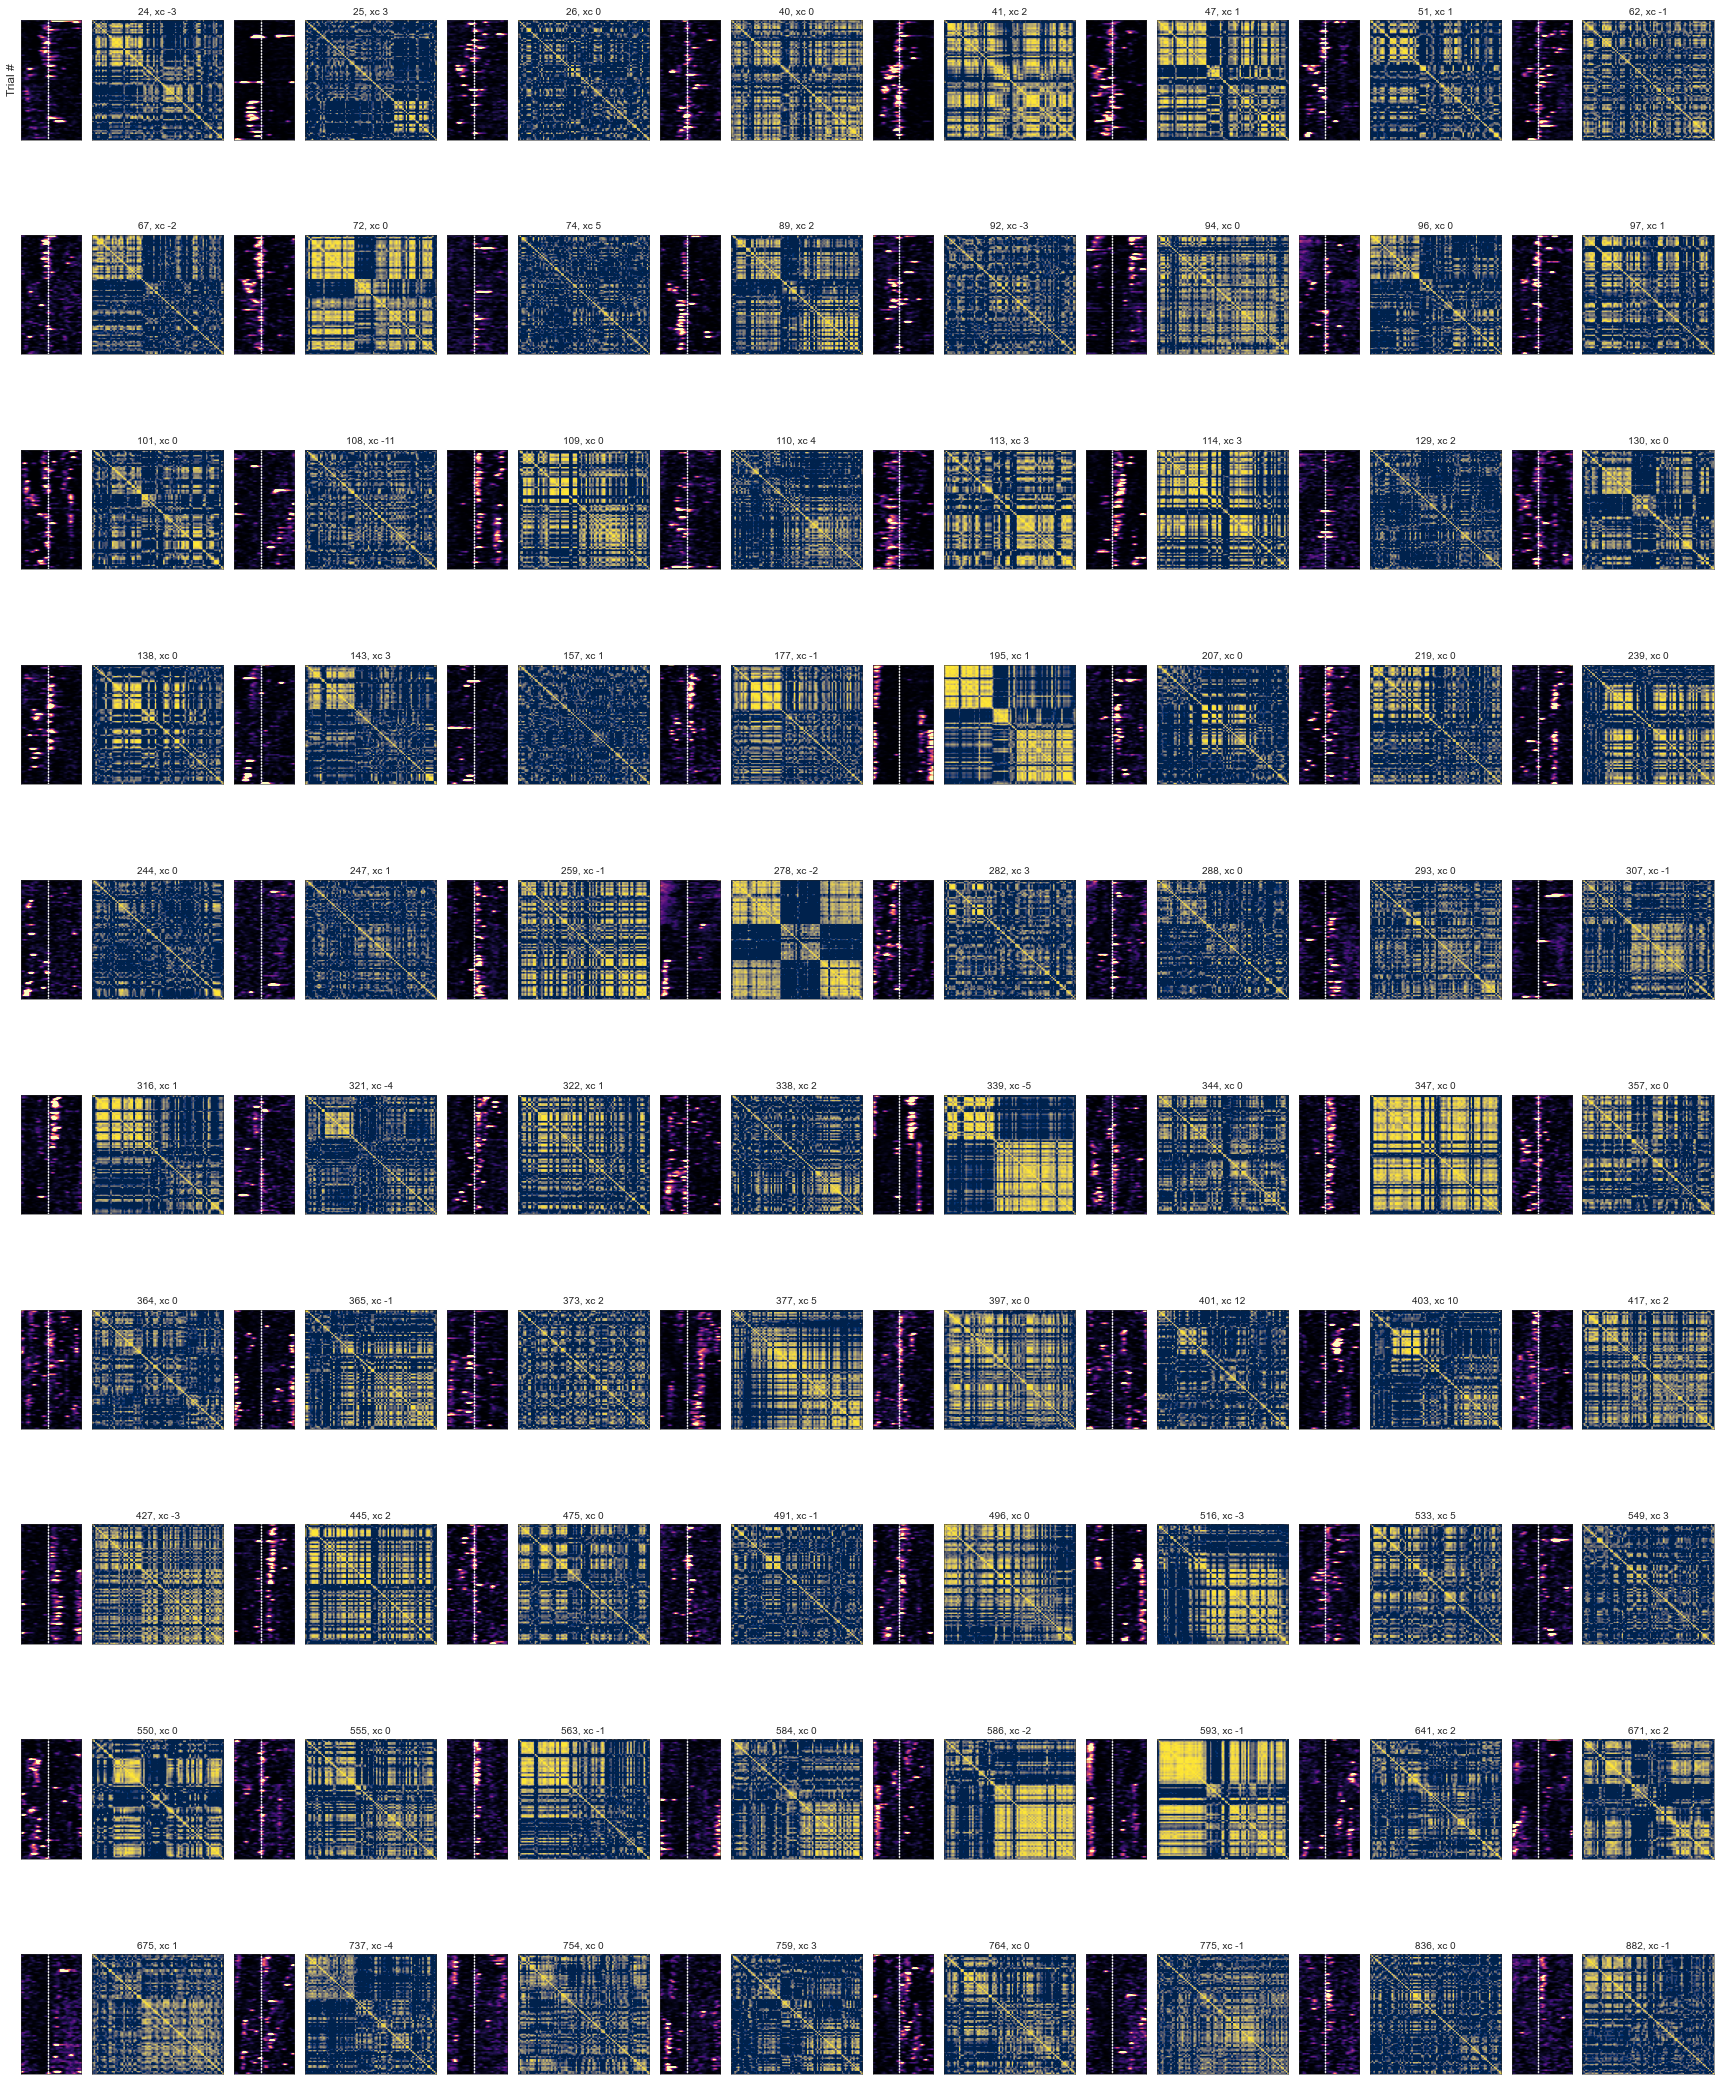

In [16]:
## Plot trials x spatial bins activity matrix plus trial-by-trial similarity matrix for each cell
category_to_plot = 'rr'
fig, figtag = placeCellPlot.plot_single_cells_w_similarity_matrix(example_an,
                                          cell_inds[category_to_plot],
                                          multi_anim_sess,
                                          sigma=1,
                                          circ_shift=True, # set True to circularly align reward zones
                                          sim_method='correlation',
                                           )
save_figures = False
if save_figures:
    figname = ("%s_expday%d_singlecell-sim_mat_%s_%s.pdf"
            % (example_an, example_day, category_to_plot, figtag,
              )
              )
    
    fig.savefig(
        os.path.join(
            fig_dir,
            figname,
        )
    )

### Count cells by remapping type

[Table of Contents](#Table-of-contents)

In [ ]:
# Get fraction of reward relative cells out of place cells and out of all cells, per animal and day
# NOTE! RR cells will be excluded from all the other categories unless otherwise noted.
#   in "switch" animals, this should exclude almost 0 track-relative cells, but in fixed-condition
#   animals or on "stay" days it will exclude a lot 
#   (basically all the cells that are stable relative to reward). 
#   Turn off this exclusion if desired with 
#   bool "exclude_rr_from_others = False"
switch_days = [3,5,7,8,10,12,14]
anim_list = multiDayData[exp_days[-1]].anim_list

df_count = pd.DataFrame(columns=['mouse',
                              'day',
                              'n_total',
                              'n_pcs_or',
                              'n_rr',
                              'fraction_pcs',
                              'fraction_pcs_set0',
                              'fraction_pcs_set1',
                              'fraction_rr_total',
                              ])

for an in anim_list:

    for day in exp_days: #switch_days: #exp_days

        if an in multiDayData[day].place_cell_masks.keys():
            n_pcs_or = np.sum(multiDayData[day].overall_place_cell_masks[an])
            # n_pcs_or = np.sum(np.logical_or(multiDayData[day].place_cell_masks[an]['set 0'],
            #                   multiDayData[day].place_cell_masks[an]['set 1']
            #                  ))
            n_pcs_set0 = np.sum(
                multiDayData[day].place_cell_masks[an]['set 0'])
            n_pcs_set1 = np.sum(
                multiDayData[day].place_cell_masks[an]['set 1'])

            n_total = len(multiDayData[day].place_cell_masks[an]['set 0']) # all cells imaged
            n_rr = len(multiDayData[day].reward_rel_cell_ids[an])
            f_pcs = n_pcs_or / n_total
            f_rr_total = n_rr / n_total
            f_rr_pc = n_rr / n_pcs_or  
            f_pcs_0 = n_pcs_set0 / n_total
            f_pcs_1 = n_pcs_set1 / n_total

            n_out, inds_per_class = dd.get_cell_class_n(multiDayData, day, an, 
                                                        exclude_rr_from_others=True,
                                                       verbose=False)
        else:
            n_pcs_or = np.nan
            n_total = np.nan
            n_rr = np.nan
            f_pcs = np.nan
            f_rr_total = np.nan
            f_rr_pc = np.nan
            f_pcs_0 = np.nan
            f_pcs_1 = np.nan

        df_count = df_count.append({'mouse': an,
                              'day': float(day),
                              'n_total': n_total,
                              'n_pcs_or': n_pcs_or,
                              'n_rr': n_rr,
                              'fraction_pcs': f_pcs,
                              'fraction_pcs_set0': f_pcs_0,
                              'fraction_pcs_set1': f_pcs_1,
                              'fraction_rr_total': f_rr_total,
                              'frac_rr_pcs': f_rr_pc,
                              'frac_reward_pcs': n_out['reward']/n_pcs_or,
                              'frac_reward_inc_rr_pcs': n_out['reward_inc_rr']/n_pcs_or,
                              'frac_nonreward_remap_pcs': n_out['nonreward_remap']/n_pcs_or,
                              'frac_nonreward_remap_inc_rr_pcs': n_out['nonreward_remap_inc_rr']/n_pcs_or,
                              'frac_track_pcs': n_out['track']/n_pcs_or,
                              'frac_appear_pcs': n_out['appear']/n_pcs_or,
                              'frac_disappear_pcs': n_out['disappear']/n_pcs_or,
                              'frac_unclassified':n_out['unclassified']/n_pcs_or,

                              },
                             ignore_index=True)


df_count

In [18]:
# range of n neurons imaged per session across all animals
print('all: n total min %d, max %d' % (df_count['n_total'].min(), df_count['n_total'].max()))

all: n total min 155, max 2172


In [19]:
# mean and std of n total cells imaged in switch animals
include_ans = multiDayData[3].circ_rel_stats_across_an['include_ans']
control_ans = ['GCAMP2', 'GCAMP6','GCAMP10']
df_count_switch = df_count[df_count['mouse'].isin(include_ans)]
df_count_control = df_count[df_count['mouse'].isin(control_ans)]
print('switch: n total mean %d, std %d' % (df_count_switch['n_total'].mean(), 
                                           df_count_switch['n_total'].std()))
print('switch: n place mean %d, std %d' % (df_count_switch['n_pcs_or'].mean(), 
                                           df_count_switch['n_pcs_or'].std()))
print('switch: frac place mean %.3f, std %.3f' % (df_count_switch['fraction_pcs'].mean(), 
                                              df_count_switch['fraction_pcs'].std()))


switch: n total mean 954, std 453
switch: n place mean 459, std 263
switch: frac place mean 0.485, std 0.145


In [20]:
# print fractions of subtypes for switch animals, specifically within environment
print('switch: frac track-relative mean %.3f, std %.3f' % (
    df_count_switch['frac_track_pcs'][df_count_switch['day'] != 8].mean(),                                                           
    df_count_switch['frac_track_pcs'][df_count_switch['day'] != 8].std()))

print('switch: frac disappear mean %.3f, std %.3f, sem %.3f' % (
    df_count_switch['frac_disappear_pcs'][df_count_switch['day'] != 8].mean(),                                                                
    df_count_switch['frac_disappear_pcs'][df_count_switch['day'] != 8].std(),
    ut.sem(df_count_switch['frac_disappear_pcs'][df_count_switch['day'] != 8]))
     )

print('switch: frac appear mean %.3f, std %.3f, sem %.3f' % (
    df_count_switch['frac_appear_pcs'][df_count_switch['day'] != 8].mean(),                                                             
    df_count_switch['frac_appear_pcs'][df_count_switch['day'] != 8].std(),
    ut.sem(df_count_switch['frac_appear_pcs'][df_count_switch['day'] != 8]))
     )

print('switch: frac reward -inc rr- mean %.3f, std %.3f' % (
    df_count_switch['frac_reward_inc_rr_pcs'][df_count_switch['day'] != 8].mean(),                                                            
    df_count_switch['frac_reward_inc_rr_pcs'][df_count_switch['day'] != 8].std())
     )

print('switch: frac nonreward_remap -inc rr- mean %.3f, std %.3f' % (
    df_count_switch['frac_nonreward_remap_inc_rr_pcs'][df_count_switch['day'] != 8].mean(),                                                                     
    df_count_switch['frac_nonreward_remap_inc_rr_pcs'][df_count_switch['day'] != 8].std())
     )

print('switch: frac nonRR_remap mean %.3f, std %.3f' % (
    df_count_switch['frac_nonreward_remap_pcs'][df_count_switch['day'] != 8].mean(),                                                        
    df_count_switch['frac_nonreward_remap_pcs'][df_count_switch['day'] != 8].std())
     )

print('switch within: frac RR mean %.3f, std %.3f' % (
    df_count_switch['frac_rr_pcs'][df_count_switch['day'] != 8].mean(),                                                      
    df_count_switch['frac_rr_pcs'][df_count_switch['day'] != 8].std())
     )

print('switch all: frac RR mean %.3f, std %.3f' % (
    df_count_switch['frac_rr_pcs'].mean(),                                                   
    df_count_switch['frac_rr_pcs'].std())
     )
print('switch: frac unclassified mean %.3f, std %.3f' % (
    df_count_switch['frac_unclassified'][df_count_switch['day'] != 8].mean(),                                                         
    df_count_switch['frac_unclassified'][df_count_switch['day'] != 8].std())
     )

switch: frac track-relative mean 0.214, std 0.079
switch: frac disappear mean 0.112, std 0.070, sem 0.009
switch: frac appear mean 0.068, std 0.040, sem 0.005
switch: frac reward -inc rr- mean 0.048, std 0.033
switch: frac nonreward_remap -inc rr- mean 0.156, std 0.036
switch: frac nonRR_remap mean 0.119, std 0.030
switch within: frac RR mean 0.161, std 0.056
switch all: frac RR mean 0.163, std 0.053
switch: frac unclassified mean 0.314, std 0.143


In [21]:
# fraction reward relative on the first switch
print('switch: frac RR mean %.3f, std %.3f' % (
    df_count_switch['frac_rr_pcs'][df_count_switch['day']==3].mean(),                                                
    df_count_switch['frac_rr_pcs'][df_count_switch['day']==3].std())
     )

switch: frac RR mean 0.137, std 0.039


In [22]:
# fraction reward relative on the last switch
print('switch: frac RR mean %.3f, std %.3f' % (
    df_count_switch['frac_rr_pcs'][df_count_switch['day']==14].mean(),                                          
    df_count_switch['frac_rr_pcs'][df_count_switch['day']==14].std())
     )

switch: frac RR mean 0.194, std 0.052


In [23]:
# track-relative on day 8, across environments
print('switch: frac track-relative day 8 across env mean %.3f, std %.3f' % (
    df_count_switch['frac_track_pcs'][df_count_switch['day']==8].mean(), 
    df_count_switch['frac_track_pcs'][df_count_switch['day']==8].std())
     )

switch: frac track-relative day 8 across env mean 0.084, std 0.031


In [24]:
# track-relative on all other days
print('switch: frac track-relative within env mean %.3f, std %.3f' % (
    df_count_switch['frac_track_pcs'][df_count_switch['day']!=8].mean(),
    df_count_switch['frac_track_pcs'][df_count_switch['day']!=8].std())
     )

switch: frac track-relative within env mean 0.214, std 0.079


# Circular analysis to test whether fraction of reward-relative cells exceeds chance

[Table of contents](#Table-of-contents)

In [ ]:
## Scatter for individual animals with shuffle

exclude_track_cells_here=True # whether to exclude track-relative cells 
exclude_reward_cells_here=False # whether to exclude cells within 50 cm from reward zone start
exclude_end_cells_here=False # whether to exclude cells with a peak in the first or last spatial bin
use_and_cells=True # here we restrict to cells with significant spatial information before and after the switch

circ_bin_size = 2*np.pi/(450/10)
tm_bin_edges= np.arange(-np.pi, np.pi + circ_bin_size, circ_bin_size)
tm_bin_centers = tm_bin_edges[:-1] + circ_bin_size / 2

day = 14
fig, ax = plt.subplots(len(multiDayData[day].anim_list), 2, 
                       figsize=(5*2, 4*len(multiDayData[day].anim_list)))
bool_to_include, inds_to_include = multiDayData[day].filter_place_cells_posthoc(
            exclude_track_cells=exclude_track_cells_here,
            exclude_reward_cells=exclude_reward_cells_here,
            exclude_end_cells=exclude_end_cells_here,
            use_and_cells=use_and_cells,
        )

for an_i, an in enumerate(multiDayData[day].anim_list):
    
    inds = inds_to_include[an]
    
    ax[an_i, 0].plot([-np.pi, np.pi], [-np.pi, np.pi],
                             '--', color='grey', alpha=0.7)
    ax[an_i, 1].plot([-np.pi, np.pi], [-np.pi, np.pi],
                     '--', color='grey', alpha=0.7)

    jitter = (np.random.random_sample(len(inds)) - 0.5) * (np.pi/50)

    circ_peaks_0 = spatial.peak(np.nanmean(
                multiDayData[day].circ_map[an]['set 0'][:,:,inds], axis=0, keepdims=True),
                tm_bin_centers, axis=1)
    circ_peaks_1 = spatial.peak(np.nanmean(
        multiDayData[day].circ_map[an]['set 1'][:,:,inds], axis=0, keepdims=True),
        tm_bin_centers, axis=1)
    
    # plot null remapping distribution
    # just plot the first shuffle
    plot_null = multiDayData[day].rel_null[an]['set 1'][0, bool_to_include[an]] 
    # ^ indexing should be right here if all original place cells minus ints were included
    ax[an_i, 1].scatter(multiDayData[day].rel_null[an]['set 0'][bool_to_include[an]]+jitter,
                        plot_null+jitter, s=20, color='red', alpha=0.5, label=f'an {an}')
        
    h = ax[an_i, 0].scatter(circ_peaks_0+jitter,
                            circ_peaks_1+jitter, s=20, color='black',
                            alpha=0.5, label=f'an {an}')

    ax[an_i, 1].scatter(multiDayData[day].rel_peaks[an]['set 0'][bool_to_include[an]]+jitter,
                        multiDayData[day].rel_peaks[an]['set 1'][bool_to_include[an]]+jitter, s=20, color='black',
                        alpha=0.5, label=f'an {an}')

    ax[an_i,0].axis('square')
    rzone0 = spatial.pos_cm_to_rad(multiDayData[day].rzone_pos[an]['set 0'][0],450,0)
    rzone1 = spatial.pos_cm_to_rad(multiDayData[day].rzone_pos[an]['set 1'][0],450,0)
    ax[an_i, 0].vlines(rzone0, -np.pi, np.pi, color='grey')
    ax[an_i, 0].hlines(rzone1, -np.pi, np.pi, color='grey')
    # ax[an_i,0].set_xticks([-3,-2,-1,0,1,2,3])
    ax[an_i,0].set_xticks(np.arange(-np.pi,np.pi + 2*np.pi/9, 2*np.pi/9))
    ax[an_i,0].set_xticklabels(np.arange(0,500,50))
    ax[an_i,0].set_yticks(np.arange(-np.pi,np.pi + 2*np.pi/9, 2*np.pi/9))
    ax[an_i,0].set_yticklabels(np.arange(0,500,50))
    ax[an_i,1].axis('square')
    ax[an_i, 1].vlines(0, -np.pi, np.pi, color='grey')
    ax[an_i, 1].hlines(0, -np.pi, np.pi, color='grey')
    ax[an_i,1].set_xticks([-3,-2,-1,0,1,2,3])
    
    xx = np.arange(-np.pi, np.pi, circ_bin_size)
    y1 = xx + multiDayData[day].circ_rel_stats_across_an['rdist_to_rad_inc']
    y2 = xx - multiDayData[day].circ_rel_stats_across_an['rdist_to_rad_inc']
    ax[an_i,1].fill_between(xx,
                            y1,
                            y2,
                            facecolor='orange',
                            alpha=0.3)

    ax[an_i, 0].set_title(an)

save_figures = False
if save_figures:
    if exclude_track_cells_here:
        excTag = 'excTR'
    else:
        excTag = ''
        
    pt.savefig(fig, fig_dir, "indivDay%d-indivAn%s_scatterRelCircPeaks_%s_%s_%s_linticks_neuralShuf_%s" % (
        day, ut.make_anim_tag(max_anim_list), ts_key, circ_tag, place_cell_logical, excTag)
    )

### Plot Fig. 2 histograms and scatters across animals

Switching from "or" to "and" place cells
Switching from "or" to "and" place cells
Switching from "or" to "and" place cells
Switching from "or" to "and" place cells
Switching from "or" to "and" place cells
Switching from "or" to "and" place cells
Switching from "or" to "and" place cells


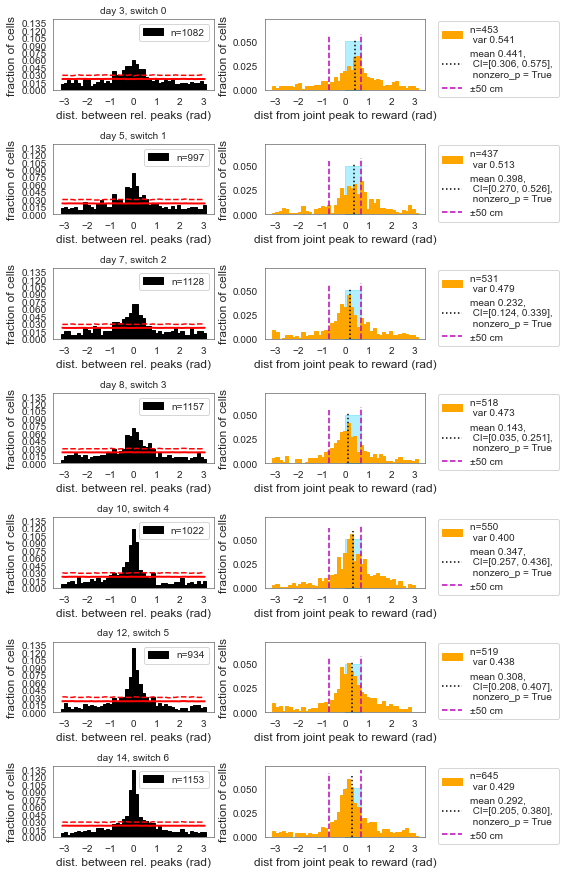

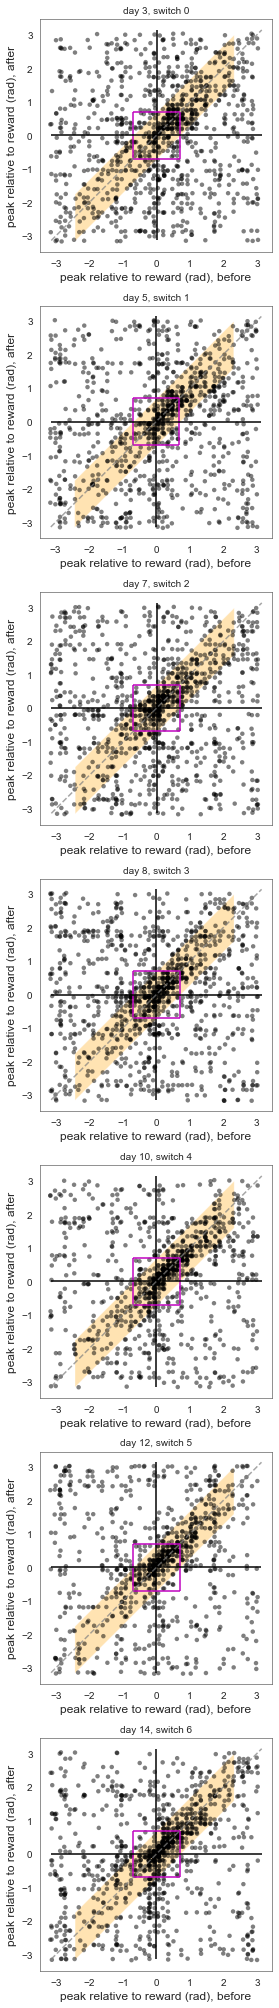

In [29]:
exclude_reward_here = False
exclude_track_here = True
use_and_cells_here = True
excTag = ''
if exclude_track_here:
    excTag += 'excTR'
if exclude_reward_here:
    excTag += '_excRew'
if use_and_cells_here:
    excTag += '_AND'
    
fig1, fig2, frac_above_shuf_acrossAn = dd.plot_rew_rel_hist_across_an(
    multiDayData, bin_size = (2*np.pi)/45, dot_edges='off', 
    exclude_reward_cells = exclude_reward_here,
    exclude_track_cells = exclude_track_here,
    use_and_cells = use_and_cells_here,
    return_frac_above_shuf = True)

In [41]:
save_figures = False
include_ans = multiDayData[exp_days[0]].circ_rel_stats_across_an['include_ans']
if save_figures:
    pt.savefig(fig1, fig_dir, "%s_expday%s_histRelCircPeakDist_%s_%s_vs_ShufMean95CI" % (
        ut.make_anim_tag(include_ans), ut.make_day_tag(exp_days), ts_key, excTag,
    )
    )
    
    pt.savefig(fig2, fig_dir, "%s_expday%s_scatterRelCircPeaks_%s_%s_candZone_jittered" % (
        ut.make_anim_tag(include_ans), ut.make_day_tag(exp_days), ts_key, excTag,),
               extension = '.svg'
    )


saving  /data/InVivoDA/fig_scratch/Sep2024/3-4-7-11-12-13-14-15-17-18-19_expday3-5-7-8-10-12-14_histRelCircPeakDist_dff_excTR_AND_vs_ShufMean95CI.svg
saving  /data/InVivoDA/fig_scratch/Sep2024/3-4-7-11-12-13-14-15-17-18-19_expday3-5-7-8-10-12-14_scatterRelCircPeaks_dff_excTR_AND_candZone_jittered.svg


# Fraction above Shuffle

[Back to table of contents](#Table-of-contents)

In [30]:
frac_above_shuf_acrossAn

{3: 0.1266173752310536,
 5: 0.14543630892678033,
 7: 0.16666666666666669,
 8: 0.14861711322385482,
 10: 0.2436399217221135,
 12: 0.2504817987152035,
 14: 0.26192541196877706}

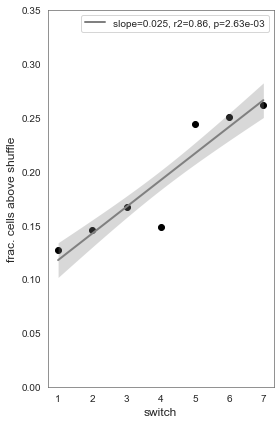

In [31]:
fig, ax = plt.subplots(figsize=(4, 6))

above_shuf = [frac_above_shuf_acrossAn[day] for day in exp_days]
# results are almost identical regressing against switch num vs. exp day
switch_num = np.arange(len(exp_days))+1

ax.scatter(switch_num, above_shuf, color='black')
ax.set_ylabel('frac. cells above shuffle')
ax.set_ylim([0, 0.35])
slope, intercept, line, reg_params = regression.linear_reg(switch_num,
                                                           np.array(above_shuf))
h = pt.plot_mean_sem(ax, line['y'], line['std'], xvalues=line['x'],
                     color='grey',
                     label=('slope=%.3f, r2=%.2f, p=%.2e' % (slope,
                                                             reg_params['r2'],
                                                             reg_params['p'])))
ax.set_xticks(switch_num)
ax.set_xlabel('switch')
ax.legend()

save_figures = False

if save_figures:
    pt.savefig(fig, fig_dir, "%s_expday%s_fracAboveShuf_%s_%s_bySwitchNum" % (
        ut.make_anim_tag(include_ans), ut.make_day_tag(exp_days), ts_key, excTag)
    )

### Linear mixed effects model (LMM) on fraction above shuffle, requiring fractions per individual animal

In [ ]:
# Plot individual animals 
# each row is a day
exclude_reward_here = False
exclude_track_here = True
use_and_cells_here = True

fig1, fig2, fig3, frac_above_shuf_indivAn = dd.plot_rew_rel_hist_indiv_an(multiDayData, 
                                                                  exclude_reward_cells=exclude_reward_here,
                                                                  exclude_track_cells=exclude_track_here,
                                                                          use_and_cells = use_and_cells_here,
                                                                  ylim_max=[0.5,0.6],
                                                                 return_frac_above_shuf=True,
                                                                 bin_size=(2*np.pi)/45)

excTag = ''
if exclude_track_here:
    excTag += 'excTR'
if exclude_reward_here:
    excTag += '_excRew'
if use_and_cells_here:
    excTag += '_AND'
    
save_figures = False
if save_figures:
    pt.savefig(fig1, fig_dir, "indivAn%s_expday%s_histRelCircPeakDist_%s_%s_95_neuralShuf" % (
        ut.make_anim_tag(include_ans), ut.make_day_tag(exp_days), ts_key, excTag)
    )
save_figures = False
if save_figures:
    pt.savefig(fig2, fig_dir, "indivAn%s_expday%s_histUnityDist_%s_%s_95_neuralShuf" % (
        ut.make_anim_tag(include_ans), ut.make_day_tag(exp_days), ts_key, excTag)
    )
save_figures = False
if save_figures:
    pt.savefig(fig3, fig_dir, "indivAn%s_expday%s_scatterRelCircPeaks-unityDistr_%s_%s_neuralShuf" % (
        ut.make_anim_tag(include_ans), ut.make_day_tag(exp_days), ts_key, excTag)
    )

In [34]:
include_ans = multiDayData[exp_days[0]].circ_rel_stats_across_an['include_ans']
include_ans

array(['GCAMP3', 'GCAMP4', 'GCAMP7', 'GCAMP11', 'GCAMP12', 'GCAMP13',
       'GCAMP14', 'GCAMP15', 'GCAMP17', 'GCAMP18', 'GCAMP19'], dtype='<U7')

In [35]:
# Convert to a dataframe for easy use of statsmodels package
# Perform logit transform on fractions to make them more normally distributed

dict_to_enter = {'frac_above_shuffle': frac_above_shuf_indivAn} 
df_f = dd.dayData_to_df(multiDayData, ['frac_above_shuffle'], anim_list=include_ans, manual_dict=dict_to_enter)
df_f['frac_logit'] = sp.special.logit(ut.avoid_naninf(df_f['frac_above_shuffle'].values))

In [36]:
## Run LMM and display results
lmmf = smf.mixedlm('frac_logit ~ 1 + switch', groups='mouse', re_formula = '~1', data=df_f,
                  missing='drop').fit(reml=True)

print(lmmf.summary())
print(lmmf.wald_test_terms())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: frac_logit
No. Observations: 69      Method:             REML      
No. Groups:       11      Scale:              0.5543    
Min. group size:  3       Log-Likelihood:     -83.7506  
Max. group size:  7       Converged:          Yes       
Mean group size:  6.3                                   
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    -2.727    0.193 -14.158 0.000 -3.105 -2.350
switch        0.187    0.046   4.066 0.000  0.097  0.278
mouse Var     0.093    0.113                            

                 chi2        P>chi2  df constraint
Intercept  200.447949  1.667554e-45              1
switch      16.535356  4.775133e-05              1


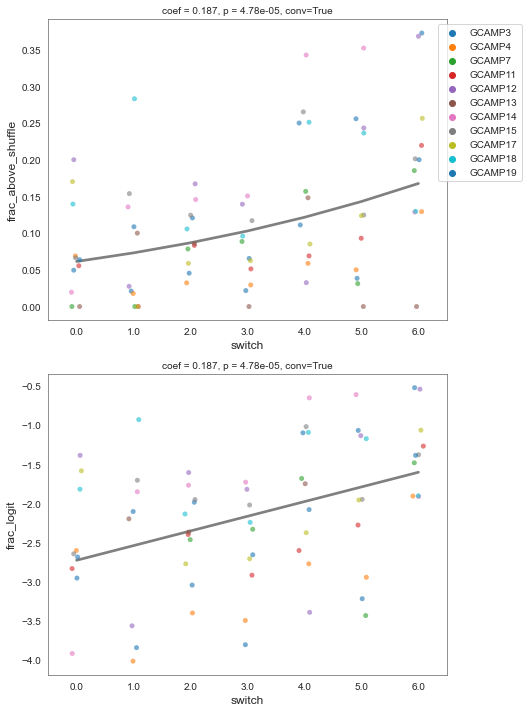

In [37]:
fig, ax = plt.subplots(2,1,figsize = (7.5,10))
# Top row: fit on the logit-transformed fractions, display expit transform of logit
# (display points and model fit in fractions)
pt.lmm_plot('switch','frac_above_shuffle',df_f,subject='mouse',ax=ax[0], markers='', 
            logit_expit=True, legend_on=True)
# Bottom row: fit on the logit-transformed fractions, display logit transform
pt.lmm_plot('switch','frac_logit',df_f,subject='mouse',ax=ax[1], markers='', 
            logit_expit=False, legend_on=False)
save_figures=False

if save_figures:
    pt.savefig(fig, fig_dir, "%s_expday%s_fracAboveShuf_LMM_%s_%s_%s_logit-expit_neuralShuf" % (
            ut.make_anim_tag(include_ans),ut.make_day_tag(exp_days), ts_key, circ_tag, place_cell_logical)
               )

# From Ext Data Fig 2 
### Compare xcorr and Pearson r for all cells, if xcorr has been saved

[Table of contents](#Table-of-contents)

In [ ]:
# first in reward-relative coordinates (that's what RR means here, not that this is specific to "RR" cells)
all_xcp_RR = []
all_r_vals_RR = []
all_p_vals_RR = []

# booleans to lookup cell classes in the list of PLACE CELLS (not all cells)
all_is_rr = []
all_is_track = []
all_is_nonrrr = []

category = 'all_place_cells' #'nonreward_remap'

for an in include_ans:
# an = 'GCAMP14'
# day = 14
    for day in exp_days:
        circ_bin_size = (2*np.pi)/45

        if category == 'rr':
            pc_masks = multiDayData[day].reward_rel_cell_ids[an]
        elif category == 'all_place_cells':
            pc_masks = multiDayData[day].overall_place_cell_masks[an]
        else:
            pc_masks = multiDayData[day].cell_class[an]['masks'][category]
            
        cells_to_plot = np.where(pc_masks)[0]
        
        use_tm_for_pearson = np.copy(multiDayData[day].circ_trial_matrix[an][0][:, :, pc_masks])
        
        tmp_track = np.where(multiDayData[day].cell_class[an]['masks']['track'])[0]
        tmp_track = tmp_track[~np.isin(
                tmp_track, multiDayData[day].reward_rel_cell_ids[an])]
        is_track = np.isin(cells_to_plot,
                            tmp_track)
        
        tmp_nonrrr = np.where(multiDayData[day].cell_class[an]['masks']['nonreward_remap'])[0]
        tmp_nonrrr = tmp_nonrrr[~np.isin(
                tmp_nonrrr, multiDayData[day].reward_rel_cell_ids[an])]
        is_nonrrr = np.isin(cells_to_plot,
                            tmp_nonrrr)

        is_rr = np.isin(cells_to_plot, multiDayData[day].reward_rel_cell_ids[an])
        all_is_track.append(is_track.tolist())
        all_is_nonrrr.append(is_nonrrr.tolist())
        all_is_rr.append(is_rr.tolist())

        rzone0 = multiDayData[day].rzone_pos[an]['set 0']
        rzone1 = multiDayData[day].rzone_pos[an]['set 1']
        circ_rzone0=spatial.pos_cm_to_rad(
            multiDayData[day].rzone_pos[an]['set 0'], 450, 0)
        circ_rzone1=spatial.pos_cm_to_rad(
            multiDayData[day].rzone_pos[an]['set 1'], 450, 0)

        if rzone0[0] > rzone1[0]:
            shift = int(np.round((circ_rzone0[0]-circ_rzone1[0])/circ_bin_size))
        elif rzone1[0] > rzone0[0]:
            shift = -int(np.round((circ_rzone1[0]-circ_rzone0[0])/circ_bin_size))

        # circularly align the trial matrix to reward zones
        use_tm_for_pearson[multiDayData[day].trial_dict[an]['trial_set1']] = np.roll(
            use_tm_for_pearson[multiDayData[day].trial_dict[an]['trial_set1']], 
            shift, 
            axis=1
        )

        r_vals = np.zeros((len(cells_to_plot),))*np.nan
        p_vals = np.zeros((len(cells_to_plot),))*np.nan

        # compute Pearson corr of trial-averaged activity
        for c_i,c in tqdm(enumerate(cells_to_plot)):
            r_vals[c_i], p_vals[c_i] = sp.stats.pearsonr(
                np.nanmean(use_tm_for_pearson[multiDayData[day].trial_dict[an]['trial_set0']][:,:,c_i],axis=0),
                np.nanmean(use_tm_for_pearson[multiDayData[day].trial_dict[an]['trial_set1']][:,:,c_i],axis=0)
            )
        
        xcp = multiDayData[day].xcorr_above_shuf[an][pc_masks]
        all_xcp_RR.append(xcp.tolist())
        all_r_vals_RR.append(r_vals.tolist())
        all_p_vals_RR.append(p_vals.tolist())
        

all_p_vals_RR = np.concatenate(np.asarray(all_p_vals_RR))
all_xcp_RR = np.concatenate(np.asarray(all_xcp_RR))
all_r_vals_RR = np.concatenate(np.asarray(all_r_vals_RR))
all_is_rr = np.concatenate(np.asarray(all_is_rr))
all_is_track = np.concatenate(np.asarray(all_is_track))
all_is_nonrrr = np.concatenate(np.asarray(all_is_nonrrr))

In [ ]:
# same thing but in track relative coordinates (here we have to compute the xcorr)

all_xcp_TR = []
all_r_vals_TR = []
all_p_vals_TR = []

category = 'all_place_cells' #'nonreward_remap'

for an in include_ans:
# an = 'GCAMP14'
# day = 14
    for day in exp_days:

        if category == 'rr':
            pc_masks = multiDayData[day].reward_rel_cell_ids[an]
        elif category == 'all_place_cells':
            pc_masks = multiDayData[day].overall_place_cell_masks[an]
        else:
            pc_masks = multiDayData[day].cell_class[an]['masks'][category]
        use_tm_for_pearson = np.copy(multiDayData[day].circ_trial_matrix[an][0][:, :, pc_masks])

        rzone0 = multiDayData[day].rzone_pos[an]['set 0']
        rzone1 = multiDayData[day].rzone_pos[an]['set 1']
        circ_rzone0=spatial.pos_cm_to_rad(
            multiDayData[day].rzone_pos[an]['set 0'], 450, 0)
        circ_rzone1=spatial.pos_cm_to_rad(
            multiDayData[day].rzone_pos[an]['set 1'], 450, 0)

        # not the most efficient because we're computing xcorr for all place cells when 
        # we could just do it for stable, rr, nonreward_remap
        _, xcp=dd.calc_field_xcorr(multiDayData[day].circ_trial_matrix[an],
                                  multiDayData[day].trial_dict[an],
                             rzone0[0],
                                  rzone1[0], 
                             circ_rzone0[0], 
                                  circ_rzone1[0], 
                             n_perms=500, 
                                  circ_shift=False,
                            cell_subset=pc_masks)


        cells_to_plot = np.where(pc_masks)[0]
        r_vals = np.zeros((len(cells_to_plot),))*np.nan
        p_vals = np.zeros((len(cells_to_plot),))*np.nan

        for c_i,c in tqdm(enumerate(cells_to_plot)):
            r_vals[c_i], p_vals[c_i] = sp.stats.pearsonr(
                np.nanmean(use_tm_for_pearson[multiDayData[day].trial_dict[an]['trial_set0']][:,:,c_i],axis=0),
                np.nanmean(use_tm_for_pearson[multiDayData[day].trial_dict[an]['trial_set1']][:,:,c_i],axis=0)
            )
        
        all_xcp_TR.append(xcp.tolist())
        all_r_vals_TR.append(r_vals.tolist())
        all_p_vals_TR.append(p_vals.tolist())

all_p_vals_TR = np.concatenate(np.asarray(all_p_vals_TR))
all_xcp_TR = np.concatenate(np.asarray(all_xcp_TR))
all_r_vals_TR = np.concatenate(np.asarray(all_r_vals_TR))

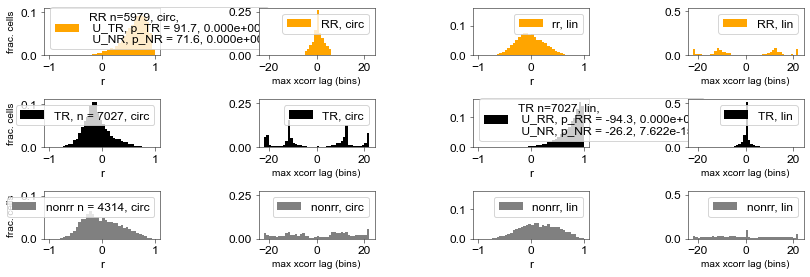

In [77]:
# Plot r value histograms
sig_r_vals_RR = all_p_vals_RR < .05
sig_r_vals_TR = all_p_vals_TR < .05

fig, ax = plt.subplots(3,4,figsize=(12,4), sharey='col')

# stats for RR cells, compared to TR and nonRR
U_TR, p_TR = sp.stats.ranksums(all_r_vals_RR[all_is_rr],all_r_vals_RR[all_is_track])
U_NR, p_NR = sp.stats.ranksums(all_r_vals_RR[all_is_rr],all_r_vals_RR[all_is_nonrrr])
pt.histogram(all_r_vals_RR[all_is_rr], ax=ax[0,0], bins=np.arange(-1,1.05,0.05), plot=True, 
             label='RR n=%d, circ, \n U_TR, p_TR = %.1f, %.3e \n U_NR, p_NR = %.1f, %.3e' % (
             np.sum(all_is_rr), U_TR, p_TR, U_NR, p_NR),
             facecolor='orange',
             edgecolor = 'none'
            )
pt.histogram(all_r_vals_RR[all_is_track], ax=ax[1,0], bins=np.arange(-1,1.05,0.05), 
             label='TR, n = %s, circ' % (np.sum(all_is_track)),
             facecolor='black',
            edgecolor = 'none')
pt.histogram(all_r_vals_RR[all_is_nonrrr], ax=ax[2,0], bins=np.arange(-1,1.05,0.05),
             label='nonrr n = %s, circ' % (np.sum(all_is_nonrrr)),
             facecolor='grey',
            edgecolor = 'none')

# stats for TR cells, compared to RR and nonRR
U_RRt, p_RRt = sp.stats.ranksums(all_r_vals_TR[all_is_rr],all_r_vals_TR[all_is_track])
U_NRt, p_NRt = sp.stats.ranksums(all_r_vals_TR[all_is_rr],all_r_vals_TR[all_is_nonrrr])
pt.histogram(all_r_vals_TR[all_is_rr], ax=ax[0,2], bins=np.arange(-1,1.05,0.05),label='rr, lin',
             facecolor='orange',
            edgecolor = 'none')
pt.histogram(all_r_vals_TR[all_is_track], ax=ax[1,2], bins=np.arange(-1,1.05,0.05),
            label='TR n=%d, lin, \n U_RR, p_RR = %.1f, %.3e \n U_NR, p_NR = %.1f, %.3e' % (
             np.sum(all_is_track), U_RRt, p_RRt, U_NRt, p_NRt),
             facecolor='black',
             edgecolor = 'none'
            )
pt.histogram(all_r_vals_TR[all_is_nonrrr], ax=ax[2,2], bins=np.arange(-1,1.05,0.05),label='nonrr, lin',
             facecolor='grey',
            edgecolor = 'none')

pt.histogram(all_xcp_RR[all_is_rr], ax=ax[0,1], bins=np.arange(-22,23,1),label='RR, circ',
             facecolor='orange',
            edgecolor = 'none')
pt.histogram(all_xcp_RR[all_is_track], ax=ax[1,1], bins=np.arange(-22,23,1),label='TR, circ',
             facecolor='black',
            edgecolor = 'none')
pt.histogram(all_xcp_RR[all_is_nonrrr], ax=ax[2,1], bins=np.arange(-22,23,1),label='nonrr, circ',
             facecolor='grey',
            edgecolor = 'none')


pt.histogram(all_xcp_TR[all_is_rr], ax=ax[0,3], bins=np.arange(-22,23,1),label='RR, lin',
             facecolor='orange',
            edgecolor = 'none')
pt.histogram(all_xcp_TR[all_is_track], ax=ax[1,3], bins=np.arange(-22,23,1),label='TR, lin',
             facecolor='black',
            edgecolor = 'none')
pt.histogram(all_xcp_TR[all_is_nonrrr], ax=ax[2,3], bins=np.arange(-22,23,1),label='nonrr, lin',
             facecolor='grey',
            edgecolor = 'none')

[[ax[i,j].legend() for i in range(ax.shape[0])] for j in range(ax.shape[1])];
[[ax[i,j].set_xlabel('r') for i in range(ax.shape[0])] for j in [0,2]]
[ax[i,0].set_ylabel('frac. cells', fontsize=10) for i in range(ax.shape[0])]
[[ax[i,j].set_xlabel('max xcorr lag (bins)', fontsize=10) for i in range(ax.shape[0])] for j in [1,3]]


save_figures = False
if save_figures:
    pt.savefig(fig, fig_dir, "anim%s_expday%s_XCP-Pearson-distr_%s_%s_ranksum" % (
        ut.make_anim_tag(max_anim_list), ut.make_day_tag(exp_days), ts_key, place_cell_logical)
    )

### Plot 2D histogram of spatial firing peaks similar to Gauthier & Tank 2018 plots

11it [00:00, 1953.81it/s]
11it [00:00, 1949.11it/s]
11it [00:00, 290.57it/s]
11it [00:00, 2026.14it/s]
11it [00:00, 2030.60it/s]
11it [00:00, 2011.83it/s]
11it [00:00, 2073.22it/s]


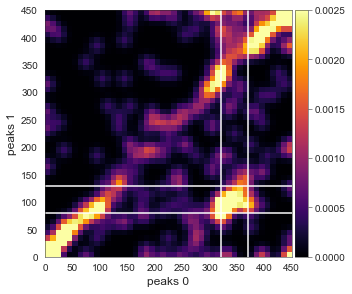

In [38]:
frac_reward = {}
frac_diag = {} 
frac_elsewhere = {}
reward_dist = 50
bin_size = 10

# whether to plot "Gauthier-style" 2D histograms
plot = True

include_ans = multiDayData[14].circ_rel_stats_across_an['include_ans']
include_tag = "-".join([ut.get_mouse_number(s) for s in include_ans])

day_list = exp_days #[:-2] #daydata.keys()

for d_i,day in enumerate(exp_days):

    frac_reward[day] = np.zeros((len(include_ans),)) * np.nan
    frac_diag[day] = np.zeros((len(include_ans),)) * np.nan
    frac_elsewhere[day] = np.zeros((len(include_ans),)) * np.nan

    for i, an in tqdm(enumerate(include_ans)):

        if (an in multiDayData[day].anim_list) and (an in include_ans):
            
            # require sig spatial information before AND after
            pc_masks_ = np.logical_and(multiDayData[day].place_cell_masks[an]['set 0'],
                                      multiDayData[day].place_cell_masks[an]['set 1'])

            peaks1_ = np.asarray(multiDayData[day].peaks[an]['set 0'])[pc_masks_]
            peaks2_ = np.asarray(multiDayData[day].peaks[an]['set 1'])[pc_masks_]

            xedges,yedges,peak_hist = spatial.smooth_hist_2d(peaks1_,peaks2_)
            _,_, peak_hist_unsm = spatial.smooth_hist_2d(peaks1_,peaks2_,smooth=False, probability=False)

            frac_reward[day][i], frac_diag[day][i], frac_elsewhere[day][i], bin_loc = spatial.get_frac_from_2D_peak_hist(
                peak_hist_unsm,
                multiDayData[day].rzone_pos[an]['set 0'][0],
                multiDayData[day].rzone_pos[an]['set 1'][0],
                                   xedges,yedges,
                                   reward_dist=reward_dist,
                                   bin_size=bin_size,
                probability=True,
                plot_bins = False,
                return_bin_loc=True
            )

            if plot:
                ## Just plot an example -- comment this out if you want to plot all of them
                if an == 'GCAMP14' and day==7:
                    fig,ax=plt.subplots(figsize=(5,5))
                    h=ax.imshow(peak_hist.T,extent=(xedges[0],xedges[-1],yedges[-1],yedges[0]),vmin=0,vmax=0.0025,cmap='inferno') 
                    #ax.imshow(not_diag_not_reward,extent=(xedges[0],xedges[-1],yedges[-1],yedges[0]),cmap='Greys_r',alpha=0.8)
                    plt.vlines(multiDayData[day].rzone_pos[an]['set 0'],0,450, color='w')
                    plt.hlines(multiDayData[day].rzone_pos[an]['set 1'],0,450, color='w')
                    ax.set_xticks(np.arange(0,450+50,50))
                    ax.set_yticks(np.arange(0,450+50,50))

                    pt.colorbar(h)

                    ax.set_xlabel('peaks 0')
                    ax.set_ylabel('peaks 1')
                    ax.invert_yaxis()
                    ax.axis('square')

                    save_figures=False

                    if save_figures:
                        figfile = os.path.join(fig_dir,"anim%s_expday%d_pc-peak-hist_ANDpcs_%s_%s.pdf" % (
                            an,day,load_ts_key,tag))
                        print(f"saving {figfile}")
                        fig.savefig(figfile)
